# Time Series Analysis - Part 4 :  ARCH and GARCH models

In this final notebook on time series analysis, we will discuss conditional heteroskedasticity, leading us to our first conditional heteroskedastic model, known as ARCH. Then we will discuss extensions to ARCH, leading us to the famous Generalised Autoregressive Conditional Heteroskedasticity model of order p,q, also known as GARCH(p,q). GARCH is used extensively within the financial industry as many asset prices are conditional heteroskedastic.

### Recap

We have considered the following models so far(it is recommended reading the series in order if you have not done so already):

* [Discrete White Noise and Random Walks](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%201.ipynb)
* [AR(p) and MA(q)](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%202.ipynb)
* [ARMA(p,q) and ARIMA(p,d,q)](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%203.ipynb)

The final piece to the puzzle is to examine conditional heteroskedasticity in detail and apply GARCH to some financial series that exhibit volatility clustering.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [48]:
import auquanToolbox.dataloader as dl

end = '2017-01-01'
start = '2010-01-01'
symbols = ['SPX']
data = dl.load_data_nologs('nasdaq', symbols , start, end)['ADJ CLOSE']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

Reading SPX
Data ends before End Date. Filling rest of the data for SPX


In [49]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## Conditional Heteroskedasticity

The main motivation for studying conditional heteroskedasticity in finance is that of volatility of asset returns.

A collection of random variables is **heteroskedastic** if there are certain groups, or subsets, of variables within the larger set that have a different variance from the remaining variables.

In finance, an increase in variance maybe correlated to a further increase in variance. For instance, on a day that equities markets undergo a substantial drop, automated risk management sell orders in long only portfolios get triggered, which lead to further fall in the price of equities within these portfolios, leading to significant downward volatility.

These "sell-off" periods, as well as many other forms of volatility, lead to heteroskedasticity that is serially correlated and hence conditional on periods of increased variance. Thus we say that such series are conditional heteroskedastic.

One of the challenging aspects of conditional heteroskedastic series is ACF plots of a series with volatility might still appear to be a realisation of stationary discrete white noise. This is despite the fact that the series is most definitely non-stationary as its variance is not constant in time.

To incorporate CH in our model, we can create a model that utilises an autoregressive process for the variance itself - a model that actually accounts for the changes in the variance over time using past values of the variance.

This is the basis of the Autoregressive Conditional Heteroskedastic (ARCH) model.


## Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series.

$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+…+\alpha_pVar(\epsilon_{t-p})+w_t$$

The actual time series is given by:

$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+…+\alpha_p\epsilon_{t-p}^2}$$

For ARCH(1), this reads:
$$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

### When To Apply ARCH(p)?

When we were attempting to fit an AR(p) model and are concerned with the decay of the $p$ lag on a ACF plot of the series, we can apply the same logic to the square of the residuals. If we find that we can apply an AR(p) to these square residuals then we have an indication that an ARCH(p) process may be appropriate.

**Note that ARCH(p) should only ever be applied to a series that has already had an appropriate model fitted sufficient to leave the residuals looking like discrete white noise**. Since we can only tell whether ARCH is appropriate or not by squaring the residuals and examining the ACF, we also need to ensure that the mean of the residuals is zero.

ARCH should only ever be applied to series that do not have any trends or seasonal effects, i.e. that has no (evident) serially correlation. ARIMA is often applied to such a series, at which point ARCH may be a good fit.



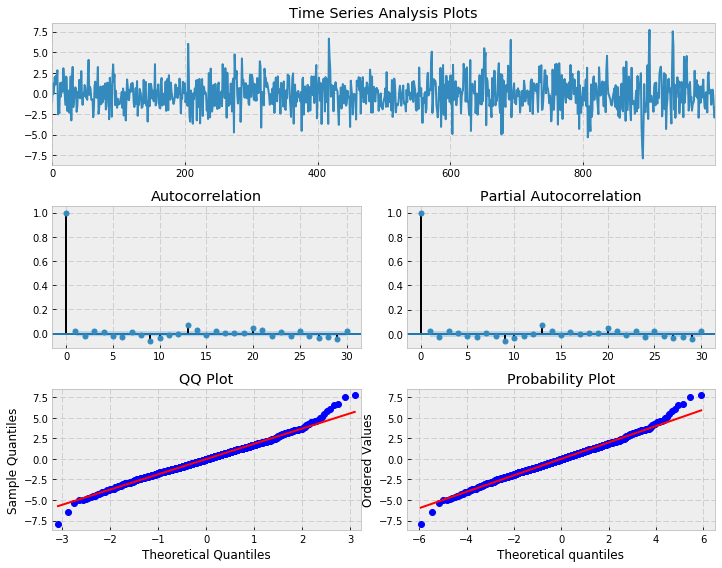

In [37]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)

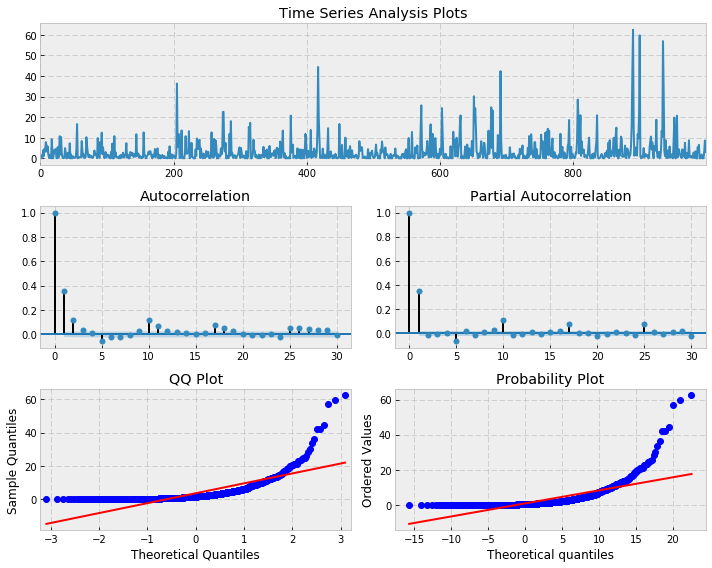

In [38]:
tsplot(y**2, lags=30)

Notice the time series looks just like white noise. However, when we plot the square of the series, the ACF, and PACF  seem to show significance at lag 1 indicating an AR(1) model for the variance may be appropriate. 

An obvious question to ask at this stage is if we are going to apply an AR(p) process to the variance, why not a Moving Average MA(q) model as well? Or a mixed model such as ARMA(p,q)?

This is actually the motivation for the Generalised ARCH model, known as GARCH

## Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process.

$$\epsilon_t = \sigma_t w_t$$

Where {wt}{wt} is discrete white noise, with zero mean and unit variance, and σ2tσt2 is given by:

$$\sigma_t^2=\alpha_0+\sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^{q}\beta_j\sigma_{t-j}^2$$

Where $\alpha_i$ and $\beta_j$ are parameters of the model.For GARCH(1,1), $\sigma^2$ is:

$$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\alpha_1 + \beta_1$ must be less than 1 or the model is unstable. We can simulate a GARCH(1, 1) process below.

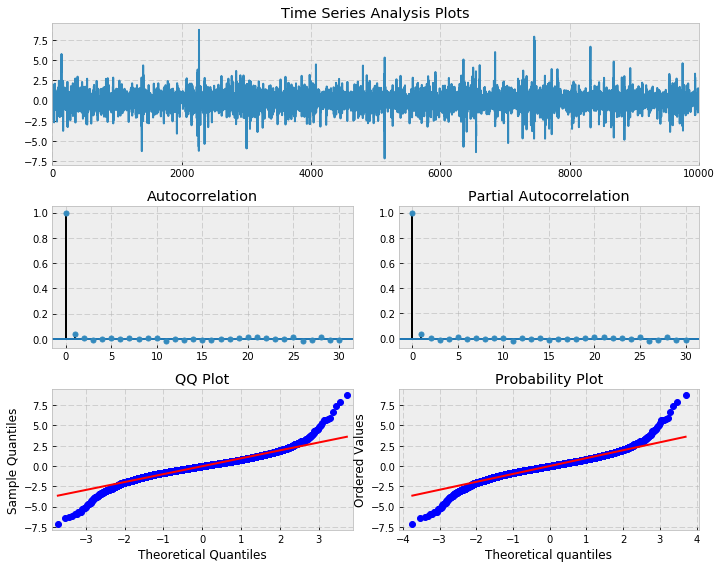

In [39]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

Again, notice that overall this process closely resembles white noise, however take a look when we view the squared eps series. 

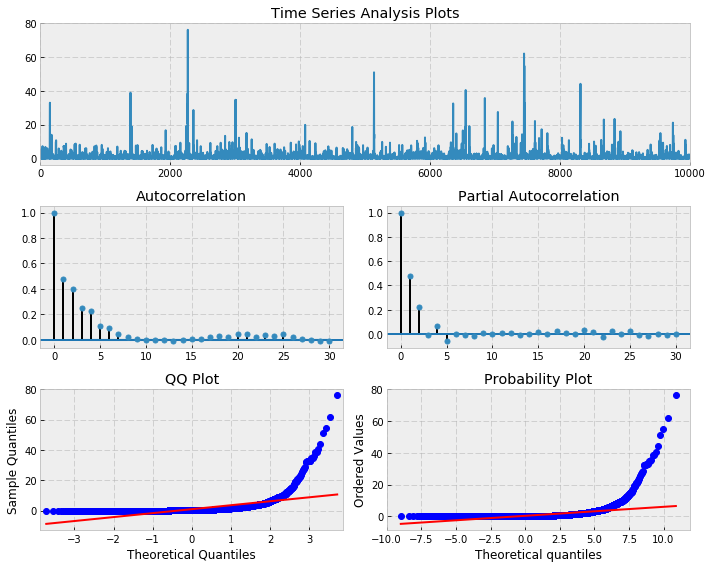

In [40]:
_ = tsplot(eps**2, lags=30)

There is substantial evidence of a conditionally heteroskedastic process via the decay of successive lags. The significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model. Let's see if we can recover our process parameters using a GARCH(1, 1) model. Here we make use of the arch_model function from the ARCH package. 

In [41]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.7950557
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.5926559
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.3032673
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Mon, Feb 27 2017   Df Residuals:                     9996
Time:                     

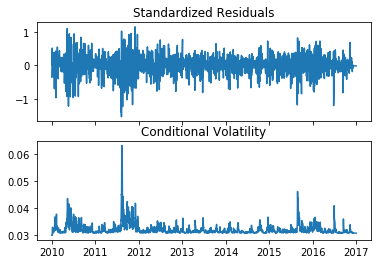

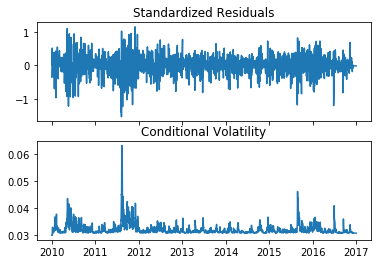

In [63]:
res.plot()

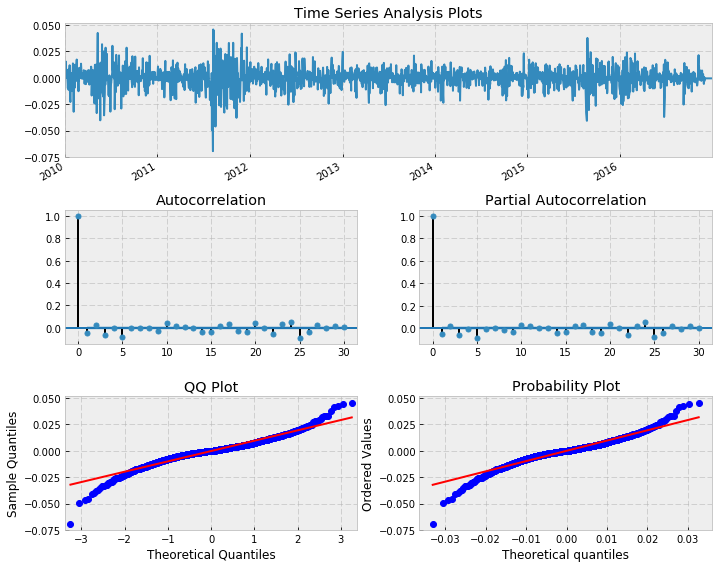

In [59]:
tsplot(res.resid,lags=30)

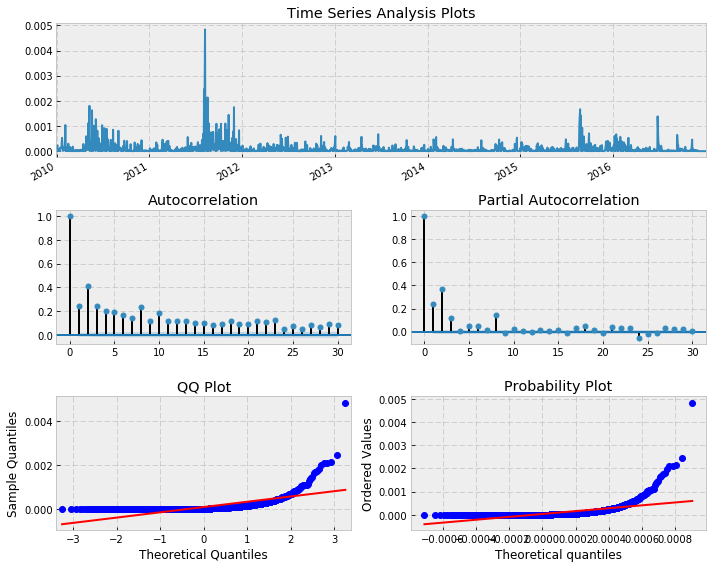

In [60]:
tsplot(res.resid**2,lags=30)

We can see that the true parameters all fall within the respective confidence intervals.

## Application to Financial Time Series

Now apply the procedure to a financial time series. Here we're going to use SPX returns. The process is as follows:

* Iterate through combinations of ARIMA(p, d, q) models to best fit our time series. 
* Pick the GARCH model orders according to the ARIMA model with lowest AIC.
* Fit the GARCH(p, q) model to our time series.
* Examine the model residuals and squared residuals for autocorrelation


Here, we first try to fotSPX return to an ARIMA process and find the best order.

In [50]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPX
res_tup = _get_best_model(TS)


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -11323.06882 | order: (3, 0, 3)


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Since we've already taken the log of returns, we should expect our integrated component d to equal zero, which it does. We find the best model is ARIMA(3,0,2).
Now we plot the residuals to decide if they possess evidence of conditional heteroskedastic behaviour

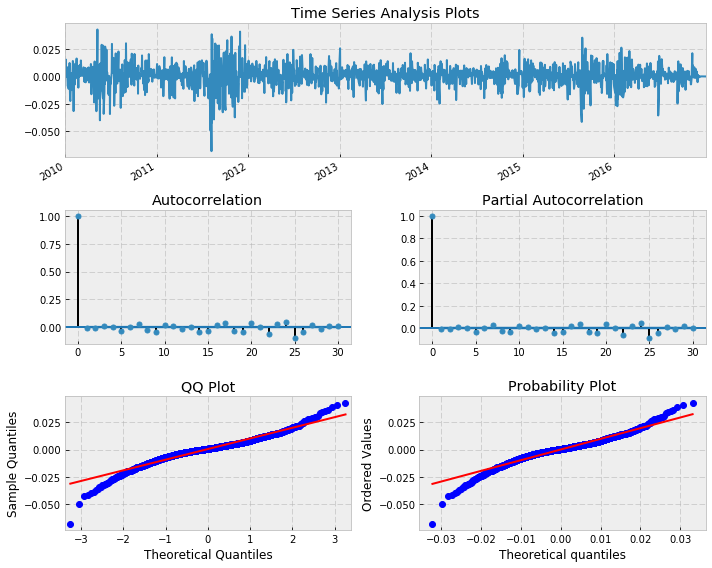

In [51]:
tsplot(res_tup[2].resid, lags=30)

We find the reiduals look like white noise. Let's look at the square of residuals

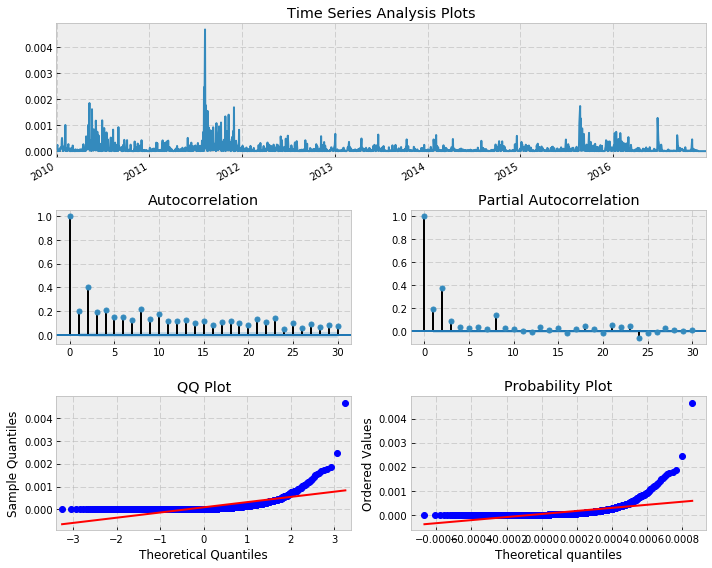

In [52]:
tsplot(res_tup[2].resid**2, lags=30)

We can see clear evidence of autocorrelation in squared residuals. Let's fit a GARCH model and see how it does.

In [64]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = res_tup[1][0]
o_ = res_tup[1][1]
q_ = res_tup[1][2]

# Using student T distribution usually provides better fit
am = arch_model(res_tup[2].resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                4532.58
Distribution:      Standardized Student's t   AIC:                          -9047.16
Method:                  Maximum Likelihood   BIC:                          -8997.88
                                              No. Observations:                 1764
Date:                      Mon, Feb 27 2017   Df Residuals:                     1755
Time:                              04:43:12   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Let's plot the residuals again

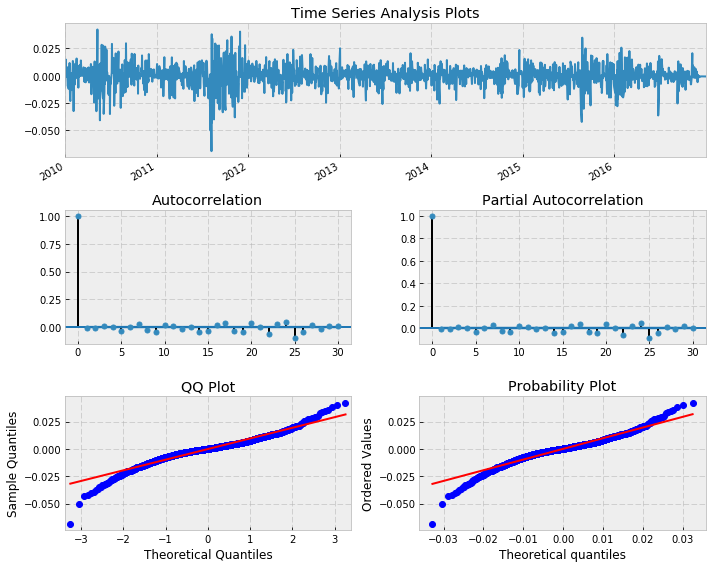

In [65]:
tsplot(res.resid, lags=30)

The plots looks like a realisation of a discrete white noise process, indicating a good fit. Let's plot a square of residuals to be sure

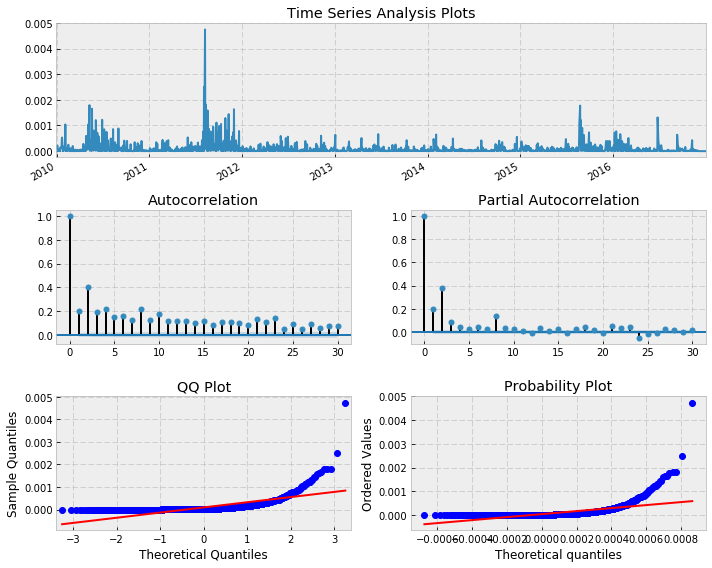

In [66]:
tsplot(res.resid**2, lags=30)

We have what looks like a realisation of a discrete white noise process, indicating that we have "explained" the serial correlation present in the squared residuals with an appropriate mixture of ARIMA(p,d,q) and GARCH(p,q).

## Next Steps

We are now at the point in our time series analysis where we have studied ARIMA and GARCH, allowing us to fit a combination of these models to a stock market index, and to determine if we have achieved a good fit or not.

The next step is to actually produce forecasts of future daily returns values from this combination and use it to create a basic trading strategy. 